In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('ETH-USD.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 3s 95ms/step - loss: 0.0239 - val_loss: 0.0118
Epoch 2/100
13/13 [==============================] - 1s 60ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 3/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 4/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 5/100
13/13 [==============================] - 1s 62ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 6/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 7/100
13/13 [==============================] - 1s 59ms/step - loss: 9.8225e-04 - val_loss: 0.0052
Epoch 8/100
13/13 [==============================] - 1s 79ms/step - loss: 9.3377e-04 - val_loss: 0.0048
Epoch 9/100
13/13 [==============================] - 1s 97ms/step - loss: 8.9539e-04 - val_loss: 0.0041
Epoch 10/100
13/13 [==============================] - 1s 100ms/step - loss: 8.4500e-04 -

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 11ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
y_train = y_train.reshape(y_train.shape[0],1)
ytest = ytest.reshape(ytest.shape[0],1)
yval = yval.reshape(yval.shape[0],1)

y_train=scaler.inverse_transform(y_train)
ytest=scaler.inverse_transform(ytest)
yval=scaler.inverse_transform(yval)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

print('Train Score: %.2f RMSE' % (math.sqrt(mean_squared_error(y_train[:,0], train_predict[:,0]))))
print('Test Score: %.2f RMSE' % (math.sqrt(mean_squared_error(ytest[:,0], y_pred[:,0]))))
print('Val Score: %.2f RMSE' % (math.sqrt(mean_squared_error(yval[:,0], y_pred_val[:,0]))))
print('Train Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_train[:,0], train_predict[:,0]))
print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(ytest[:,0], y_pred[:,0]))
print('Val Mean Absolute Percentage Error:', mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0]))
print('Train Score: %.2f MAPE' % (mean_absolute_percentage_error(y_train[:,0], train_predict[:,0])))
print('Test Score: %.2f MAPE' % (mean_absolute_percentage_error(ytest[:,0], y_pred[:,0])))
print('Val Score: %.2f MAPE' % (mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0])))

r_squared = r2_score(ytest, y_pred)
print("Test_R-squared: ", r_squared)
r_squared = r2_score(yval, y_pred_val)
print("Val_R-squared: ", r_squared)

Validation RMSE: 73.40531996995875
Testing RMSE: 161.6957347214213
Train Score: 71.12 RMSE
Test Score: 161.70 RMSE
Val Score: 73.41 RMSE
Train Mean Absolute Percentage Error: 0.052026386819172335
Test Mean Absolute Percentage Error: 0.04793812680529879
Val Mean Absolute Percentage Error: 0.03625415650613331
Train Score: 0.05 MAPE
Test Score: 0.05 MAPE
Val Score: 0.04 MAPE
Test_R-squared:  0.9773599899517469
Val_R-squared:  0.404796551765257


In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
r_squared = r2_score(ytest, y_pred)
print("Test_R-squared: ", r_squared)
r_squared = r2_score(yval, y_pred_val)
print("Val_R-squared: ", r_squared)

test_mape = mean_absolute_percentage_error(ytest, y_pred)
print("Testing MAPE",test_mape)
val_mape = mean_absolute_percentage_error(yval, y_pred_val)
print("Validation MAPE",val_mape)

Test_R-squared:  0.9773599899517469
Val_R-squared:  0.404796551765257
Testing MAPE 0.04793812680529879
Validation MAPE 0.03625415650613331


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=96
i=0
while(i<30):

    if(len(temp_input)>96):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.3587042]
97
1 day input [0.23542094 0.23057648 0.23304257 0.23254071 0.23201781 0.23290864
 0.23581711 0.23584306 0.24471132 0.24341808 0.24744149 0.24635629
 0.25126099 0.25852154 0.26171792 0.27262522 0.27899918 0.28615287
 0.30720246 0.307579   0.3127524  0.31084324 0.29972513 0.30759537
 0.33036678 0.3234341  0.32370258 0.32367476 0.3084552  0.32016125
 0.31833331 0.31728193 0.31181806 0.32747813 0.31073288 0.31481332
 0.32655134 0.32685911 0.33142709 0.33191856 0.32439589 0.32112481
 0.33296886 0.32844703 0.30629569 0.29958964 0.3049125  0.29962459
 0.29795328 0.30851275 0.33333899 0.32618488 0.33780784 0.33717825
 0.33497258 0.33948427 0.33000189 0.32685701 0.32852288 0.3194522
 0.31659333 0.3263441  0.32496531 0.3189258  0.33114841 0.32772532
 0.31112397 0.31064736 0.31012582 0.31074821 0.30958719 0.30367225
 0.2834011  0.2813825  0.29273843 0.31561152 0.33473313 0.33966098
 0.32960766 0.334076   0.35856211 0.35201403 0.35709456 0.34641911
 0.3615946  0.34692802 0.36364331 0.

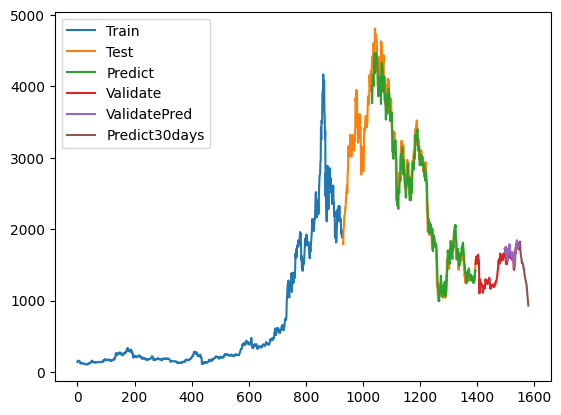

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()